In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# Change the path to the folder that the .csv result files are located in

data_folder = r"C:\Users\minel\iCloudDrive\Documents\Duke University\Naumann Lab\DOI\Gut imaging\neurod1GCaMP6s_6dpf_fed_DOI_50ugml_20220118"

In [55]:
# Change the conditions based on the file names and the timestamps

conditions = ['baseline', 'drugtreated']
fmt = '%H:%M:%S'
baseline_end = datetime.strptime('0:05:24', fmt)
drugtreated_start = datetime.strptime('0:07:31', fmt)
treatment = drugtreated_start - baseline_end
frames = int(treatment.seconds*0.2)

In [61]:
# Read the .csv files and combine them in a single dataframe. Save the combined dataframe.

dfs = []

with os.scandir(data_folder) as entries:
    for entry in entries:
        if entry.name.endswith('.csv') and entry.name.startswith(conditions[0]):
            _df = pd.read_csv(os.path.join(data_folder, entry))
            _df['condition'] = conditions[0]
            dfs.append(_df) 
            treatdf = pd.DataFrame(columns=_df.columns, index=range(frames))
            treatdf['condition'] = 'treatment'
            dfs.append(treatdf) 
        elif entry.name.endswith('.csv') and entry.name.startswith(conditions[1]):
            _df = pd.read_csv(os.path.join(data_folder, entry))
            _df['condition'] = conditions[1]
            dfs.append(_df) 

df = pd.concat(dfs, ignore_index=True)
df.rename({' ': 'slice'}, axis=1, inplace=True)
df['intdiff'] = df['Mean(gut_roi)'] - df['Mean(background_roi)']
cum_slices = list(df[df.condition == conditions[0]].slice.values)
cum_slices.extend(list(np.arange(cum_slices[-1]+1, cum_slices[-1]+frames+1)))
cum_slices.extend(cum_slices[-1] + df[df.condition == conditions[1]].slice.values)
df['cum_slice'] = cum_slices
df['norm_bgint'] = df['Mean(background_roi)'] / df['Mean(background_roi)'][0]
df['corr_intdiff'] = df.norm_bgint * df.intdiff
df['norm_corr_intdiff'] = df.corr_intdiff / np.mean(df[df.condition == conditions[0]].corr_intdiff)
df.to_hdf(os.path.join(data_folder, 'finaldf.h5'), key='finaldf', mode='w')

ValueError: Length of values (599) does not match length of index (574)

In [45]:
df[df.condition == conditions[0]].slice.values[-1] + 

60

In [30]:
# Read the finaldf.h5

df = pd.read_hdf(os.path.join(data_folder, 'finaldf.h5'))

In [31]:
# View the dataframe

df

,slice,Area(gut_roi),Mean(gut_roi),Min(gut_roi),Max(gut_roi),IntDen(gut_roi),RawIntDen(gut_roi),Area(background_roi),Mean(background_roi),Min(background_roi),Max(background_roi),IntDen(background_roi),RawIntDen(background_roi),condition,intdiff,cum_slice,norm_bgint,corr_intdiff,norm_corr_intdiff
0,1,152322,15.677,0,98,2387876,2387876,29988,3.253,0,12,97551,97551,baseline,12.424,1,1.000000,12.424000,1.024130
1,2,152322,15.679,0,90,2388219,2388219,29988,3.061,1,10,91786,91786,baseline,12.618,2,0.940978,11.873255,0.978731
2,3,152322,15.615,0,94,2378506,2378506,29988,3.314,0,10,99373,99373,baseline,12.301,3,1.018752,12.531667,1.033005
3,4,152322,15.644,0,79,2382882,2382882,29988,3.229,0,15,96821,96821,baseline,12.415,4,0.992622,12.323405,1.015838
4,5,152322,15.662,0,65,2385636,2385636,29988,3.311,0,9,99283,99283,baseline,12.351,5,1.017830,12.571215,1.036265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,510,152322,11.444,0,78,1743160,1743160,29988,2.183,0,17,65457,65457,drugtreated,9.261,570,0.671073,6.214806,0.512296
570,511,152322,11.268,0,75,1716385,1716385,29988,2.123,0,7,63669,63669,drugtreated,9.145,571,0.652628,5.968286,0.491975
571,512,152322,11.417,0,82,1739034,1739034,29988,2.120,0,8,63564,63564,drugtreated,9.297,572,0.651706,6.058912,0.499446
572,513,152322,11.338,0,82,1726951,1726951,29988,2.192,0,8,65743,65743,drugtreated,9.146,573,0.673840,6.162936,0.508021


In [32]:
# Run linear regression on the mean background intensity

linmodel = LinearRegression().fit(df.cum_slice.values.reshape((-1, 1)), df['Mean(background_roi)'].values)
r_sq = linmodel.score(df.cum_slice.values.reshape((-1, 1)), df['Mean(background_roi)'].values)
print('coefficient of determination:', r_sq)
print('intercept:', linmodel.intercept_)
print('slope:', linmodel.coef_)

y_pred = linmodel.predict(df.cum_slice.values.reshape((-1, 1)))

coefficient of determination: 0.8821626158990645
intercept: 3.081225258587665
slope: [-0.00188553]


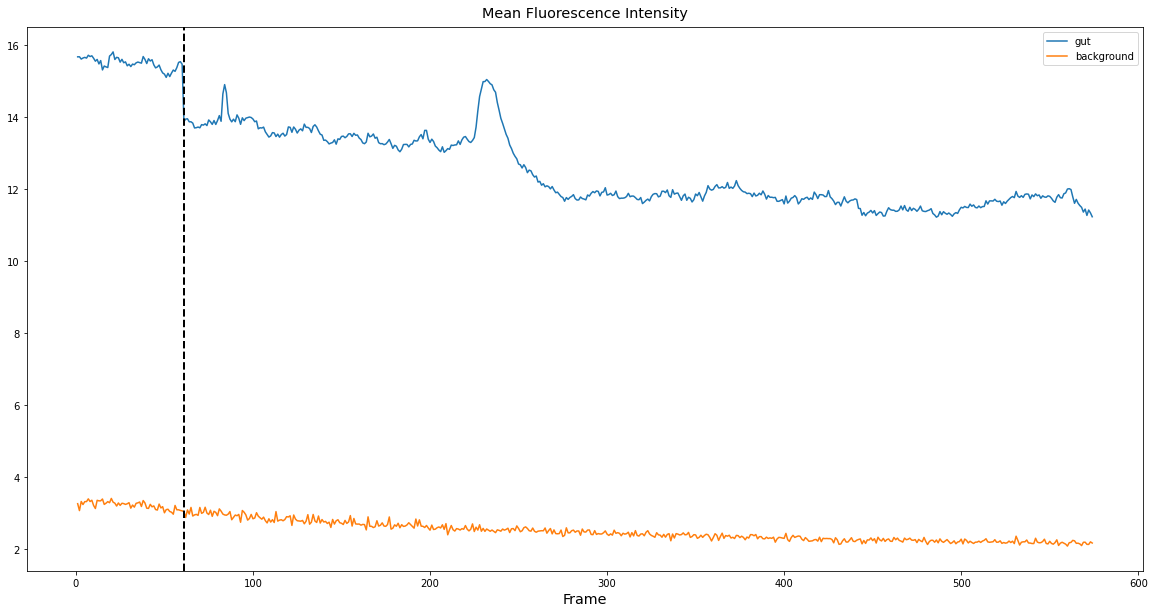

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('Mean Fluorescence Intensity', fontsize='x-large', pad=10)
plt.plot(df.cum_slice, df['Mean(gut_roi)'], label='gut')
plt.plot(df.cum_slice, df['Mean(background_roi)'], label='background')
plt.axvline(df[df.condition == conditions[1]].cum_slice.values[0], linestyle='dashed', color='black', linewidth=2)
ax.set_xlabel('Frame', fontsize='x-large')
ax.legend()
plt.savefig(os.path.join(data_folder, data_folder[data_folder.rfind('\\') + 1:] + '_meanIntensities.png'), dpi=300, transparent=False)

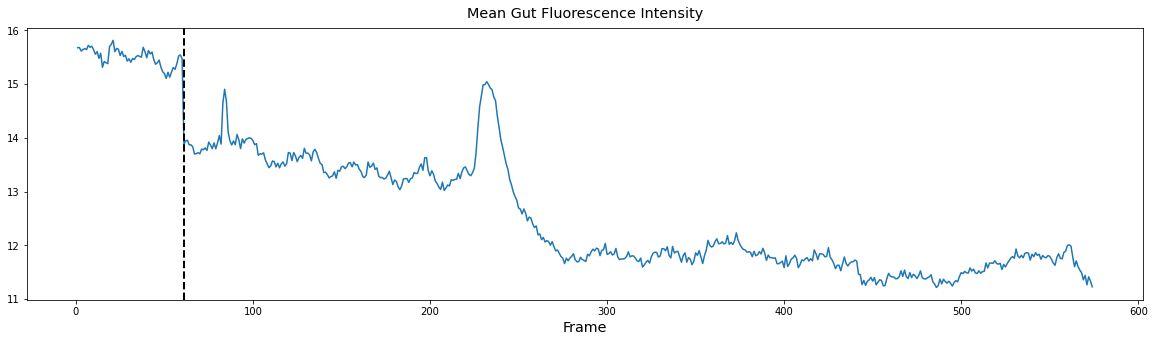

In [34]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Mean Gut Fluorescence Intensity', fontsize='x-large', pad=10)
plt.plot(df.cum_slice, df['Mean(gut_roi)'])
plt.axvline(df[df.condition == conditions[1]].cum_slice.values[0], linestyle='dashed', color='black', linewidth=2)
ax.set_xlabel('Frame', fontsize='x-large')
plt.savefig(os.path.join(data_folder, data_folder[data_folder.rfind('\\') + 1:] + '_meanGutIntensity.png'), dpi=300, transparent=False)

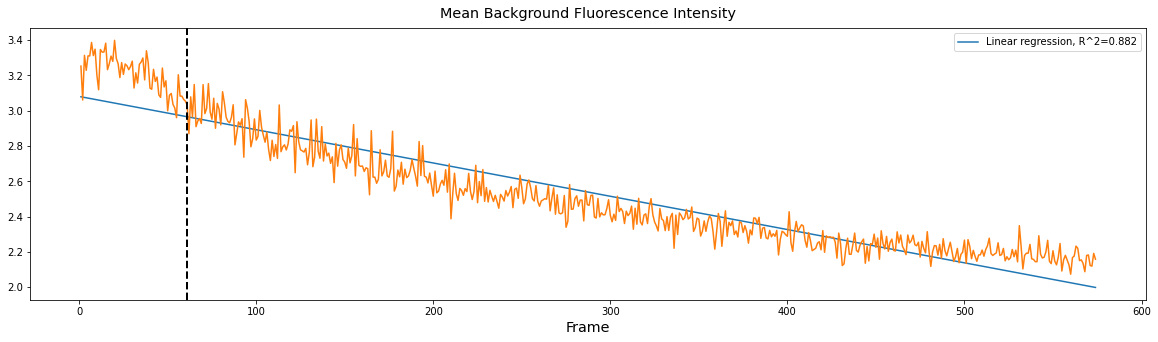

In [35]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Mean Background Fluorescence Intensity', fontsize='x-large', pad=10)
plt.plot(df.cum_slice, y_pred, label='Linear regression, R^2={:.3f}'.format(r_sq))
plt.plot(df.cum_slice, df['Mean(background_roi)'])
plt.axvline(df[df.condition == conditions[1]].cum_slice.values[0], linestyle='dashed', color='black', linewidth=2)
ax.set_xlabel('Frame', fontsize='x-large')
ax.legend()
plt.savefig(os.path.join(data_folder, data_folder[data_folder.rfind('\\') + 1:] + '_meanBackgroundIntensity.png'), dpi=300, transparent=False)

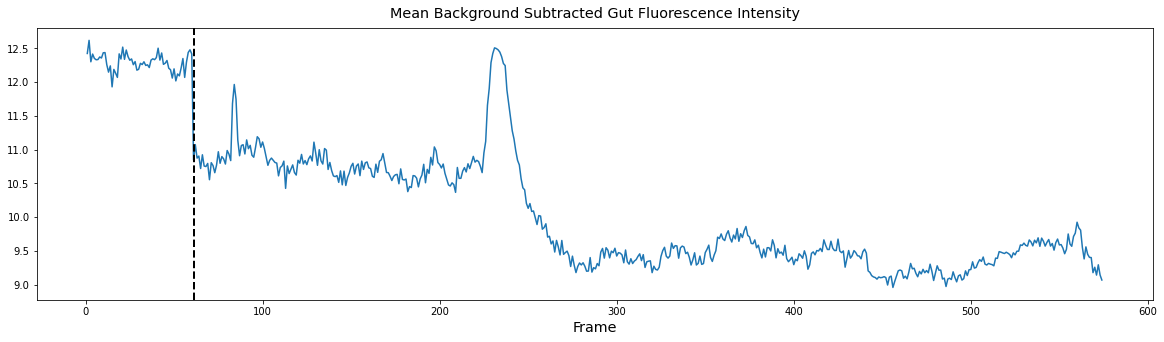

In [36]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Mean Background Subtracted Gut Fluorescence Intensity', fontsize='x-large', pad=10)
plt.plot(df.cum_slice, df.intdiff)
plt.axvline(df[df.condition == conditions[1]].cum_slice.values[0], linestyle='dashed', color='black', linewidth=2)
ax.set_xlabel('Frame', fontsize='x-large')
plt.savefig(os.path.join(data_folder, data_folder[data_folder.rfind('\\') + 1:] + '_meanBackgroundSubtractedGutIntensity.png'), dpi=300, transparent=False)

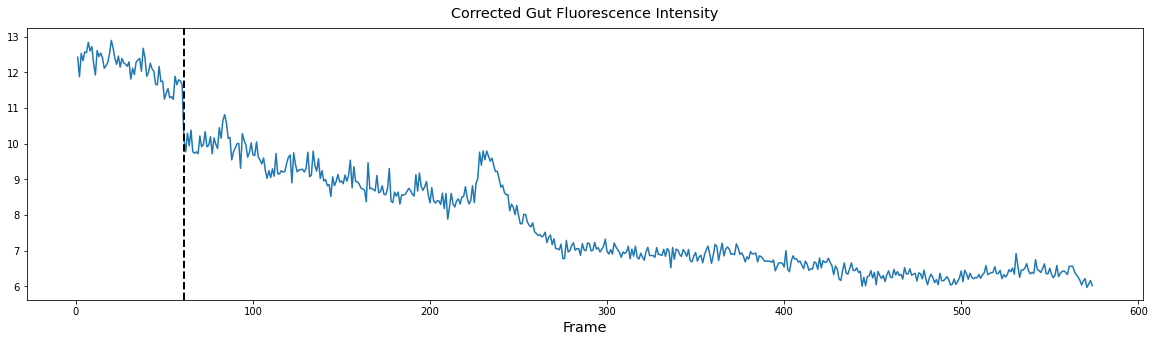

In [37]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Corrected Gut Fluorescence Intensity', fontsize='x-large', pad=10)
plt.plot(df.cum_slice, df.corr_intdiff)
plt.axvline(df[df.condition == conditions[1]].cum_slice.values[0], linestyle='dashed', color='black', linewidth=2)
ax.set_xlabel('Frame', fontsize='x-large')
plt.savefig(os.path.join(data_folder, data_folder[data_folder.rfind('\\') + 1:] + '_correctedGutIntensity.png'), dpi=300, transparent=False)

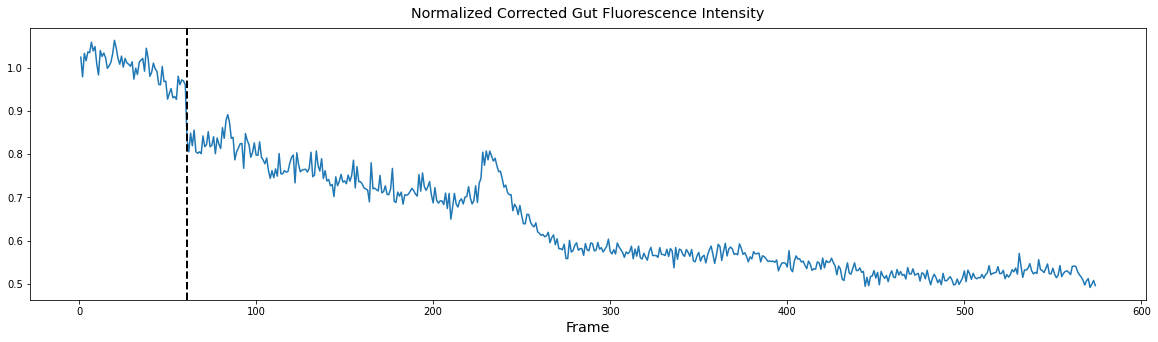

In [38]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Normalized Corrected Gut Fluorescence Intensity', fontsize='x-large', pad=10)
plt.plot(df.cum_slice, df.norm_corr_intdiff)
plt.axvline(df[df.condition == conditions[1]].cum_slice.values[0], linestyle='dashed', color='black', linewidth=2)
ax.set_xlabel('Frame', fontsize='x-large')
plt.savefig(os.path.join(data_folder, data_folder[data_folder.rfind('\\') + 1:] + '_normalizedCorrectedGutIntensity.png'), dpi=300, transparent=False)